![paleoCAMP logo](./images/paleoCAMPLogo.png)

# 3.3 More Info: Climate and Model Data Access

**Tutorials at [the 2025 paleoCAMP](https://paleoclimate.camp/) | June 16–June 30, 2025**
       
[Jiang Zhu](https://staff.cgd.ucar.edu/jiangzhu/)  
[jiangzhu@ucar.edu](mailto:jiangzhu@ucar.edu)  
Climate & Global Dynamics Laboratory  
NSF National Center for Atmospheric Research    

------

**More information and examples to demonstrate data access and analysis**
* Guidance on using climate data
* Access Earth System Model output
* NCAR [JupyterHub](https://jupyterhub.hpc.ucar.edu/) is your `one-stop shop` for data access and analysis!
  * Example 1: Access ERA5 Reanalysis on NSF NCAR's Research Data Archive
  * Example 2: Access CESM output on NCAR's Campaign Storage and perform model-data comparison 
    
**Time to go through**: 15 minutes

---
## Guidance on using climate data
- NCAR [Climate Data Guide](https://climatedataguide.ucar.edu/): Key strength, Key limitations, Expert User Guidance, etc.
  - [Atmospheric Reanalysis: Overview & Comparison Tables](https://climatedataguide.ucar.edu/climate-data/atmospheric-reanalysis-overview-comparison-tables)
  - [Paleoclimate](https://climatedataguide.ucar.edu/climate-data/paleoclimate) (You could contribute!)
  - ...

---
## Access ESM output
- Earth System Grid Federation (ESGF), e.g., the [LLNL Node](https://aims2.llnl.gov/search)
- NSF NCAR [Research Data Archive](https://rda.ucar.edu/): e.g., EAR5 Reanalysis (1.77 PB!) and iTRACE
- Other portals, such as the [DeepMIP Model Database](https://www.deepmip.org/data-eocene/)

---
## NCAR [JupyterHub](https://jupyterhub.hpc.ucar.edu/) is your `one-stop shop` for data access and analysis!
  - Multiple PB of CESM Paleoclimate simulation data
  - Other CESM simulation data
  - Preinstalled Python environment

Note: variable names may be different depending on the portals ([IPCC Standard](https://pcmdi.llnl.gov/mips/cmip3/variableList.html); [CESM Standard](https://www.cesm.ucar.edu/community-projects/lens2/output-variables))

---
Load Python packages

In [1]:
import os
import glob
from datetime import timedelta

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# xesmf is used for regridding ocean output
import xesmf

import warnings
warnings.filterwarnings("ignore")

---
### Example 1: Access ERA5 Reanalysis data on NSF NCAR's Research Data Archive
Browse the [RDA website](https://rda.ucar.edu/) and figure out the file structure
- Search `era5`
- Click the `Monthly Mean` product (d633001)
- Click the tab `DATA ACCESS`
- Total precipitation is in `ERA5 monthly mean atmospheric surface forecast (accumulated) [netCDF4]`
- Click `GLADE File Listing` to see all the files stored on the NCAR Campaign Storage 

In [2]:
data_dir = '/glade/campaign/collections/rda/data/d633001/e5.moda.fc.sfc.accumu/'

files_tp = glob.glob(data_dir + '*/*_tp.*.nc')
print(*sorted(files_tp), sep='\n')

/glade/campaign/collections/rda/data/d633001/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc
/glade/campaign/collections/rda/data/d633001/e5.moda.fc.sfc.accumu/1980/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1980010100_1980120100.nc
/glade/campaign/collections/rda/data/d633001/e5.moda.fc.sfc.accumu/1981/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1981010100_1981120100.nc
/glade/campaign/collections/rda/data/d633001/e5.moda.fc.sfc.accumu/1982/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1982010100_1982120100.nc
/glade/campaign/collections/rda/data/d633001/e5.moda.fc.sfc.accumu/1983/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1983010100_1983120100.nc
/glade/campaign/collections/rda/data/d633001/e5.moda.fc.sfc.accumu/1984/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1984010100_1984120100.nc
/glade/campaign/collections/rda/data/d633001/e5.moda.fc.sfc.accumu/1985/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1985010100_1985120100.nc
/glade/campaign/collections/rda/da

In [3]:
ds = xr.open_mfdataset(files_tp)
ds = ds.reindex(latitude=sorted(ds.latitude.values))
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 528)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
Data variables:
    TP         (time, latitude, longitude) float32 dask.array<chunksize=(3, 332, 776), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:45:33 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:45:34 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

#### Change the units from m per day to mm per day and make a plot
See [here](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790) for clarification of units.

In [4]:
tp = ds.TP.mean('time') * 1000.0
tp = tp.compute()
tp

<xarray.DataArray 'TP' (latitude: 721, longitude: 1440)>
array([[0.18871191, 0.18871191, 0.18871191, ..., 0.18871191, 0.18871191,
        0.18871191],
       [0.1763593 , 0.17630874, 0.17631234, ..., 0.17640808, 0.17640086,
        0.17640446],
       [0.17613353, 0.17612088, 0.17608838, ..., 0.17611367, 0.17612632,
        0.17613533],
       ...,
       [0.6987416 , 0.69886446, 0.6989421 , ..., 0.6986495 , 0.69864047,
        0.69868386],
       [0.7080526 , 0.7081086 , 0.70814294, ..., 0.70803094, 0.7080472 ,
        0.70808154],
       [0.7012306 , 0.7012306 , 0.7012306 , ..., 0.7012306 , 0.7012306 ,
        0.7012306 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

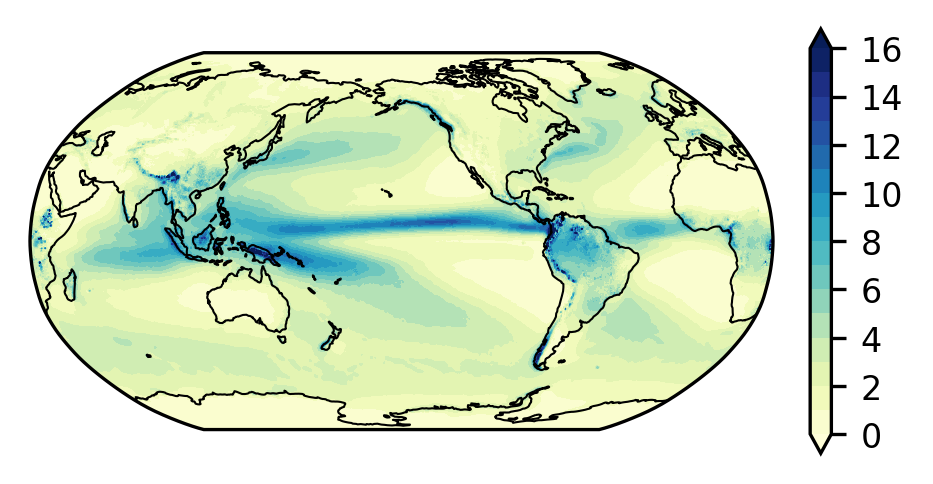

In [5]:
fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(3, 1.5),
    subplot_kw={'projection': ccrs.Robinson(central_longitude=210)},
    constrained_layout=True)

# Plot model results using contourf
p0 = ax.contourf(tp.longitude, tp.latitude, tp,
                 levels=np.linspace(0, 16, 17),
                 cmap='YlGnBu', extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p0, ax=ax)
ax.coastlines(linewidth=0.5)

---
### Example 2: Access CESM paleoclimate output and perform model-data comparison on NCAR's Campaign Storage
- We try to reproduce [Figure 2a of Jiang's paper](https://dx.doi.org/10.1029/2020GL091220) to use the LGM ΔSST to assess CESM2's climate sensitivity.
- Whole set of model output is shared at: `/glade/campaign/cesm/community/palwg`
- You can find additional simulation data here: `/glade/campaign/cgd/ppc/jiangzhu`
- We are in the process of organizing available data on the [Paleoclimate Working Group webiste](https://www.cesm.ucar.edu/working-groups/paleo)
- As for now, prior knowledge of the experiments and file structure are needed. ***We hope to develop a Simulation Catalog for this!***

In [6]:
!ls /glade/campaign/cesm/community/palwg/

ASD_paleoweather  Holocene		   LastGlacialMaximum	      TraCE
cam6_paleo_ppe	  iCESM1.2-DeglacialSlice  set_permission.csh
CESM1-LME	  iTRACE		   storage_use_policy.readme


In [7]:
!ls -l /glade/campaign/cesm/community/palwg/LastGlacialMaximum/CESM2
!ls /glade/campaign/cesm/community/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.PI.01/ocn/proc/tseries/month_1/*.TEMP.*
!ls /glade/campaign/cesm/community/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.21ka.01/ocn/proc/tseries/month_1/*.TEMP.*

total 3
drwxr-sr-x+ 7 jiangzhu cesm 4096 Aug  2  2024 b.e21.B1850CLM50SP.f09_g17.21ka.01
drwxr-sr-x+ 8 jiangzhu cesm 4096 Aug  2  2024 b.e21.B1850CLM50SP.f09_g17.PI.01
-rw-r--r--+ 1 jiangzhu cesm  413 Aug  2  2024 please_cite_zhu_etal_2021
/glade/campaign/cesm/community/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.PI.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.PI.01.pop.h.TEMP.000101-010012.nc
/glade/campaign/cesm/community/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.PI.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.PI.01.pop.h.TEMP.010101-020012.nc
/glade/campaign/cesm/community/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.PI.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.PI.01.pop.h.TEMP.020101-030012.nc
/glade/campaign/cesm/community/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.21ka.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.21ka.01.pop.h.TEMP.000101-010012.nc
/glade/campaign/cesm/community/p

In [8]:
campaign_dir = '/glade/campaign/cesm/community/palwg/LastGlacialMaximum/CESM2'
comp = 'ocn/proc/tseries/month_1'

### Read preindustrial SST

In [9]:
case = 'b.e21.B1850CLM50SP.f09_g17.PI.01'
fname = 'b.e21.B1850CLM50SP.f09_g17.PI.01.pop.h.TEMP.020101-030012.nc'

file = os.path.join(campaign_dir, case, comp, fname)

# Open the file and select the last 10 years of data
ds_pre = xr.open_dataset(file).isel(time=slice(-120, None))
sst_pre = ds_pre.TEMP.isel(z_t=0).mean('time')
sst_pre

<xarray.DataArray 'TEMP' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.9042568, -1.9034731, -1.9024575, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

### Read LGM SST

In [10]:
case = 'b.e21.B1850CLM50SP.f09_g17.21ka.01'
fname = 'b.e21.B1850CLM50SP.f09_g17.21ka.01.pop.h.TEMP.040101-050012.nc'

file = os.path.join(campaign_dir, case, comp, fname)

# Open the file and select the last 10 years of data
ds_lgm = xr.open_dataset(file).isel(time=slice(-120, None))
sst_lgm = ds_lgm.TEMP.isel(z_t=0).mean('time')
sst_lgm

<xarray.DataArray 'TEMP' (nlat: 384, nlon: 320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

### Regrid into the 1° × 1° grid using xesmf

In [11]:
%%time

ds_pre['lat'] = ds_pre.TLAT
ds_pre['lon'] = ds_pre.TLONG

regridder = xesmf.Regridder(
    ds_in=ds_pre,
    ds_out=xesmf.util.grid_global(1, 1, cf=True, lon1=360),
    method='bilinear',
    periodic=True)

dsst_1x1 = regridder(sst_lgm - sst_pre)
dsst_1x1

CPU times: user 3.97 s, sys: 176 ms, total: 4.15 s
Wall time: 4.82 s


<xarray.DataArray (lat: 180, lon: 360)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.17081444, -0.17075008, -0.17069343, ..., -0.17104828,
        -0.17096627, -0.1708865 ],
       [-0.178788  , -0.17878205, -0.17877994, ..., -0.17882909,
        -0.17881154, -0.17879783],
       [-0.18547155, -0.18547687, -0.18548317, ..., -0.18546143,
        -0.18546383, -0.1854672 ]], dtype=float32)
Coordinates:
    z_t                 float32 500.0
  * lon                 (lon) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    latitude_longitude  float64 nan
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

### Read proxy ΔSST in csv from Jess's github

In [12]:
url = 'https://raw.githubusercontent.com/jesstierney/lgmDA/master/proxyData/Tierney2020_ProxyDataPaired.csv'
proxy_dsst = pd.read_csv(url)
proxy_dsst.head()

,Latitude,Longitude,Lower2s,Median,Upper2s,ProxyType,Species
0,-55.0,73.3,-2.927296,-1.379339,0.302709,delo,pachy
1,-53.0,-58.0,1.426191,2.773898,4.253553,uk,NaN
2,-51.1,67.7,-4.810437,-3.192364,-0.570439,delo,pachy
3,-48.1,146.9,-4.784523,-3.370838,-1.886123,uk,NaN
4,-46.1,90.1,-4.949764,-3.470513,-1.919271,delo,bulloides


### Plot the LGM ΔSST in the model and proxy records

Text(0.5, 1.0, 'LGM ΔSST: CESM2 vs proxy')

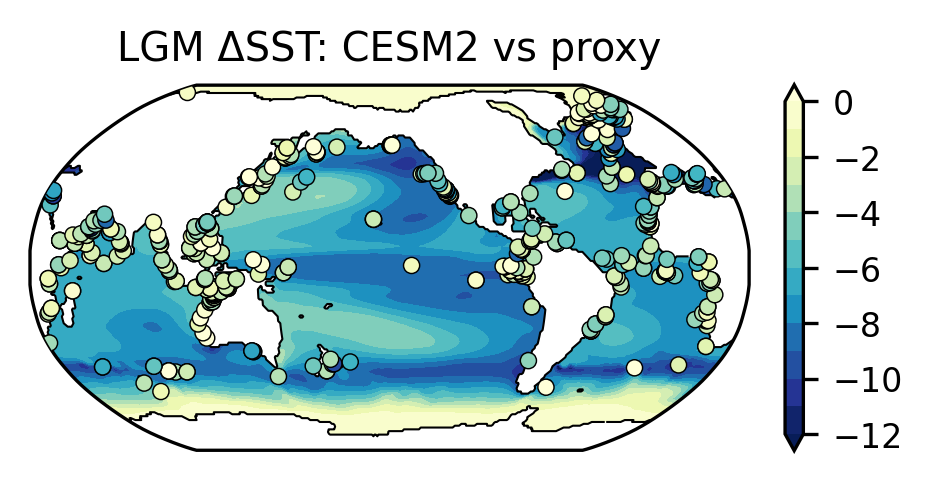

In [13]:
cmap = plt.get_cmap('YlGnBu').reversed()
norm = mpl.colors.Normalize(-12, 0)

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(3, 1.5),
                       subplot_kw={'projection': ccrs.Robinson(central_longitude=210)},
                       constrained_layout=True)

# Plot model results using contourf
dsst_1x1_new, lon_new = add_cyclic_point(dsst_1x1, dsst_1x1.lon)
p0 = ax.contourf(lon_new, dsst_1x1.lat, dsst_1x1_new,
                 levels=np.linspace(-12, 0, 13),
                 cmap=cmap, norm=norm, extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p0, ax=ax)

# Create a land-sea mask and plot the LGM coastal line
lmask = xr.where(dsst_1x1.isnull(), 0, 1)
ax.contour(lmask.lon, lmask.lat, lmask,
           levels=[0.5],
           linewidths=0.5,
           colors='black',
           transform=ccrs.PlateCarree())

# Plot proxy SST using markers
ax.scatter(proxy_dsst['Longitude'],
           proxy_dsst['Latitude'],
           c=proxy_dsst['Median'],
           marker='o',
           s=15,
           cmap=cmap,
           edgecolors='black',
           lw=0.35,
           norm=norm,
           zorder=3,
           transform=ccrs.PlateCarree())

ax.set_title("LGM ΔSST: CESM2 vs proxy")